# Experiments on SisFall dataset processing

In [45]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 5]

In [46]:
import pandas
import numpy as np

dataset_path = '../cache/SisFall_dataset/SisFall_dataset/SA01/F04_SA01_R01.txt'

In [47]:
with open(dataset_path) as f:
    for l in f:
        print(l)
        break

   0,-198, -55,-166,-181,-444, -77,-758, -49;



Like in the SisFall paper, we keep only the data from **ADXL345**.
Meaning we will keep only the first three columns from each csv file.

In [48]:
df = pandas.read_csv(dataset_path, header=None).iloc[:,:3]

As per README convert accellerometer values in g.
This let's us get features values similar to the ones in http://sistemic.udea.edu.co/wp-content/uploads/2015/11/Supplementary.pdf

In [49]:
def sensor_to_g(df):
    df.iloc[:, 0] = df[0] * (32/2**13)
    df.iloc[:, 1] = df[1] * (32/2**13)
    df.iloc[:, 2] = df[1] * (32/2**13)
    
sensor_to_g(df)

In [50]:
df

,0,1,2
0,0.000000,-0.773438,-0.003021
1,-0.027344,-0.792969,-0.003098
2,-0.031250,-0.824219,-0.003220
3,-0.039062,-0.855469,-0.003342
4,-0.027344,-0.882812,-0.003448
...,...,...,...
2995,-0.964844,0.003906,0.000015
2996,-0.957031,-0.007812,-0.000031
2997,-0.957031,0.007812,0.000031
2998,-0.968750,0.007812,0.000031


## How do you do a sliding window?

The data were collected ad a 200Hz frequency.
This means that 200 rows are collected in a second.

So how much time did the experiment take? Does the number make sense?

In the cell below we do the computation and we find out the same number reported on page 4 of the paper

In [51]:
print(f'{len(df) / 200:.2f}s {len(df) / 200 / 60:.2f}min')

15.00s 0.25min


In [52]:
def window(df, k: int, Nv:int):
    # Avoids shorter windows at the end 
    # which would give much more importance to the lateset samples
    # I use iloc[0:0] to return the columns expected
    begin = k - Nv + 1
    if begin < 0:
        return df.iloc[0:0]
    return df.iloc[begin:k+1]
    
window(df, k=6, Nv=5)

,0,1,2
2,-0.031250,-0.824219,-0.003220
3,-0.039062,-0.855469,-0.003342
4,-0.027344,-0.882812,-0.003448
5,-0.027344,-0.906250,-0.003540
6,-0.031250,-0.917969,-0.003586


## How to compute the features from SisFall Paper?

### C1 - Sum vector magnitude

C1 feature is presented with the following equation: $C1[k] = RMS(ã[k]) = \sqrt{a_x^2[k] + a_y^2[k] + a_y^2[z]}$

**R**oot **M**ean **S**quare according to wikipedia is:

Given $n$ items $\{ x_1, ..., x_n \}$
$RMS = \sqrt {\frac{1}{n} (x_1^2 + ... + x_n^2)}$

A single measurement is instead defined as $\vec{a} = [a_x, a_y, a_z]^T$

So the formula $\sqrt{a_x^2[k] + a_y^2[k] + a_y^2[z]}$ would return a single real for each measurement k.

Instead $RMS(ã[k]) = \sqrt{ \frac{1}{|ã[k]|} (\vec{a}^T[k - Nv + 1]^2 + ... + \vec{a}^T[k]^2})$, which results in a vector.

In my opinion the equation makes no sense, so let's follow the train of logic.

In the literature by *Sum vector magnitude* of a vector $\vec{a} = \sqrt{a_x^2[k] + a_y^2[k] + a_y^2[z]}$.

Also, from the literature, a feature is usually a single real value.

So it makes sense to compute sum vector magnitude for each sample, and then RMS them and provide the real result as C1.

In [53]:
def _c1(x, y, z):
    for i in range(len(x)):
        measure = np.array([x[i], y[i], z[i]])
        yield np.sqrt(np.sum(measure ** 2))

def c1(df):
    df['c1'] = list(_c1(df.iloc[:,0], df.iloc[:,1], df.iloc[:,2]))
    
c1(df)

In [54]:
df

,0,1,2,c1
0,0.000000,-0.773438,-0.003021,0.773443
1,-0.027344,-0.792969,-0.003098,0.793446
2,-0.031250,-0.824219,-0.003220,0.824817
3,-0.039062,-0.855469,-0.003342,0.856367
4,-0.027344,-0.882812,-0.003448,0.883243
...,...,...,...,...
2995,-0.964844,0.003906,0.000015,0.964852
2996,-0.957031,-0.007812,-0.000031,0.957063
2997,-0.957031,0.007812,0.000031,0.957063
2998,-0.968750,0.007812,0.000031,0.968782


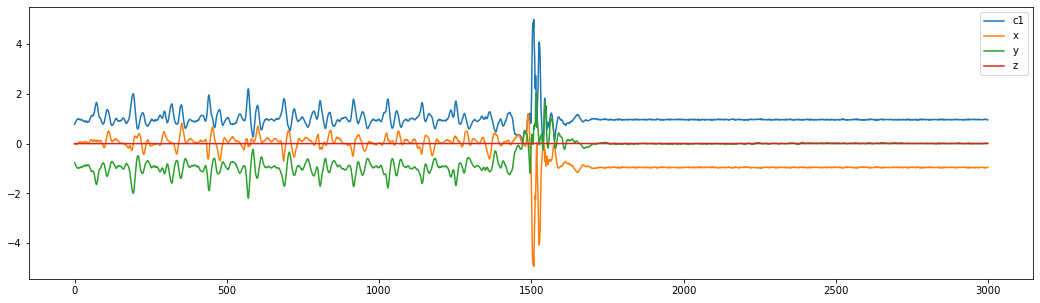

In [55]:
plt.plot(df['c1'], label='c1')
plt.plot(df.iloc[:, 0], label = 'x')
plt.plot(df.iloc[:, 1], label = 'y')
plt.plot(df.iloc[:, 2], label = 'z')
plt.legend()
plt.show()

Now that we got the **sum vector magnitude** for each sample, let's rms them by window

In [56]:
Nv = 100 # 500ms window

def wc1(df, Nv):
    k = Nv
    df['wc1'] = 0

    w = window(df, k, Nv)
    while k < len(df)-Nv:
        w_rms = np.sqrt(np.mean(np.array(w['c1']**2)))
        df.iloc[k, df.columns.get_loc("wc1")] = w_rms
        k += 1
        w = window(df, k, Nv)
        
wc1(df, Nv)

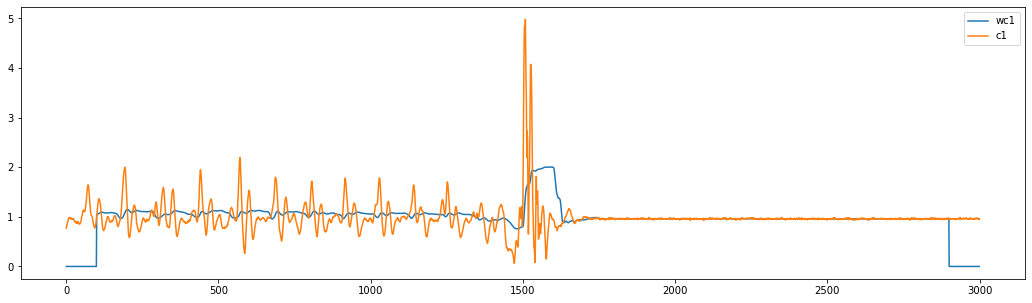

In [57]:
plt.plot(df['wc1'], label='wc1')
plt.plot(df['c1'], label='c1')
plt.legend()
plt.show()

### C2 - Sum vector magnitude on horizontal plane

I am going to follow the same logic as above.

In [58]:
def _c2(x, z):
    for i in range(len(x)):
        measure = np.array([x[i], z[i]])
        yield np.sqrt(np.sum(measure ** 2))

def c2(df):
    df['c2'] = list(_c2(df.iloc[:,0], df.iloc[:,2]))
    
c2(df)

In [59]:
df

,0,1,2,c1,wc1,c2
0,0.000000,-0.773438,-0.003021,0.773443,0.0,0.003021
1,-0.027344,-0.792969,-0.003098,0.793446,0.0,0.027519
2,-0.031250,-0.824219,-0.003220,0.824817,0.0,0.031415
3,-0.039062,-0.855469,-0.003342,0.856367,0.0,0.039205
4,-0.027344,-0.882812,-0.003448,0.883243,0.0,0.027560
...,...,...,...,...,...,...
2995,-0.964844,0.003906,0.000015,0.964852,0.0,0.964844
2996,-0.957031,-0.007812,-0.000031,0.957063,0.0,0.957031
2997,-0.957031,0.007812,0.000031,0.957063,0.0,0.957031
2998,-0.968750,0.007812,0.000031,0.968782,0.0,0.968750


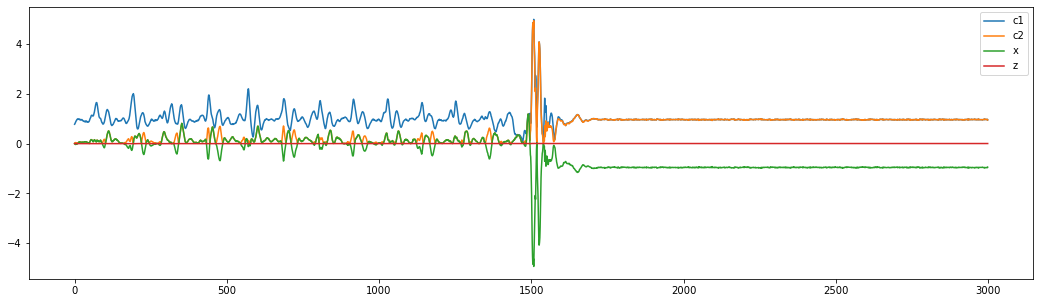

In [60]:
plt.plot(df['c1'], label='c1')
plt.plot(df['c2'], label='c2')
plt.plot(df.iloc[:, 0], label = 'x')
plt.plot(df.iloc[:, 2], label = 'z')
plt.legend()
plt.show()

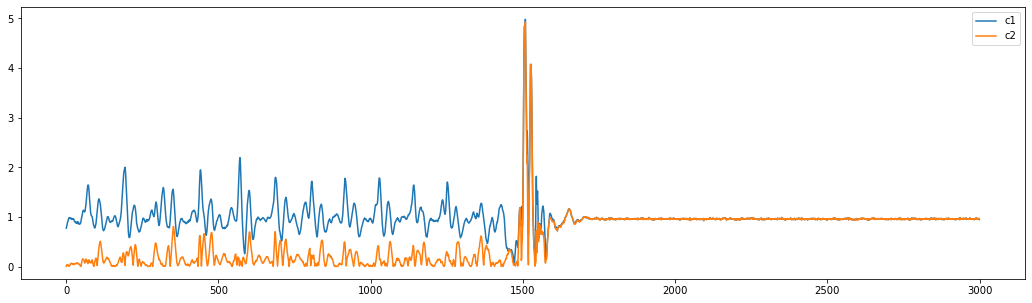

In [61]:
plt.plot(df['c1'], label='c1')
plt.plot(df['c2'], label='c2')
plt.legend()
plt.show()

In [62]:
Nv = 100 # 500ms window

def wc2(df, Nv):
    df['wc2'] = 0
    k = Nv

    w = window(df, k, Nv)
    while k < len(df)-Nv:
        w_rms = np.sqrt(np.mean(np.array(w['c2']**2)))
        df.iloc[k, df.columns.get_loc("wc2")] = w_rms
        k += 1
        w = window(df, k, Nv)
        
wc2(df, Nv)

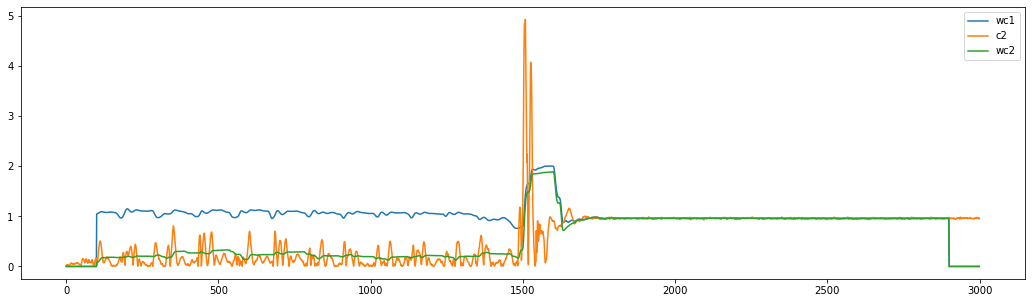

In [63]:
plt.plot(df['wc1'], label='wc1')
plt.plot(df['c2'], label='c2')
plt.plot(df['wc2'], label='wc2')
plt.legend()
plt.show()

### C3 - Maximum peak-to-peak acceleration amplitude

In the paper is defined as $C3[k] = RMS(max(ã[k]) - min(ã[k]))$

It's a mistery to me what does max/min mean on a list of vectors.

My best guess, as above, is to treat $max(ã[k])$ as the maximum C1 of one of the vectors in $[\vec{a}^T[k - Nv + 1], ..., \vec{a}^T[k]]$. The same for the min.

In [64]:
window(df, 10, Nv=5)['c1'].argmax()

3

In [65]:
window(df, 10, Nv=5)

,0,1,2,c1,wc1,c2,wc2
6,-0.031250,-0.917969,-0.003586,0.918508,0.0,0.031455,0.0
7,-0.031250,-0.949219,-0.003708,0.949740,0.0,0.031469,0.0
8,-0.015625,-0.957031,-0.003738,0.957166,0.0,0.016066,0.0
9,-0.003906,-0.980469,-0.003830,0.980484,0.0,0.005471,0.0
10,-0.007812,-0.972656,-0.003799,0.972695,0.0,0.008687,0.0


In [66]:
window(df, 10, Nv=5)['c1'].argmin()

0

In [67]:
f'C3 would be {window(df, 10, Nv=5).iloc[4,3] - window(df, 10, Nv=5).iloc[0,3]} for k = 10'

'C3 would be 0.05418753516773889 for k = 10'

In [68]:
Nv = 100 # 500ms window

def c3(df):
    df['c3'] = 0
    k = Nv

    w = window(df, k, Nv)
    while k < len(df)-Nv:
        i_min = w['c1'].argmin()
        i_max = w['c1'].argmax()
        ptp = w.iloc[i_max, w.columns.get_loc("c1")] - w.iloc[i_min, w.columns.get_loc("c1")]
        df.iloc[k, df.columns.get_loc("c3")] = ptp
        k += 1
        w = window(df, k, Nv)
    
    df = df.dropna()
    
c3(df)

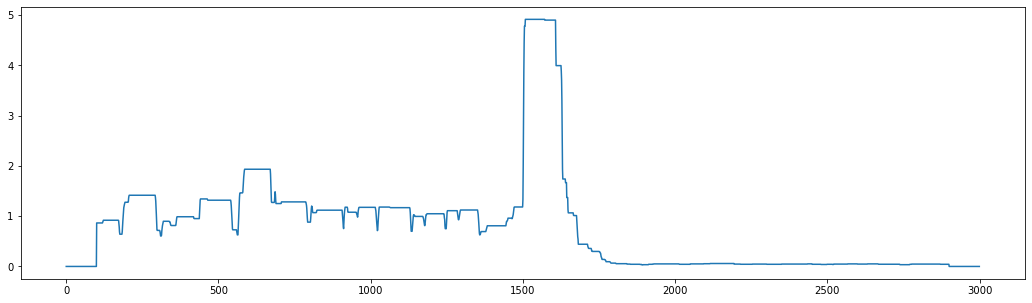

In [69]:
plt.plot(df['c3'])
plt.show()

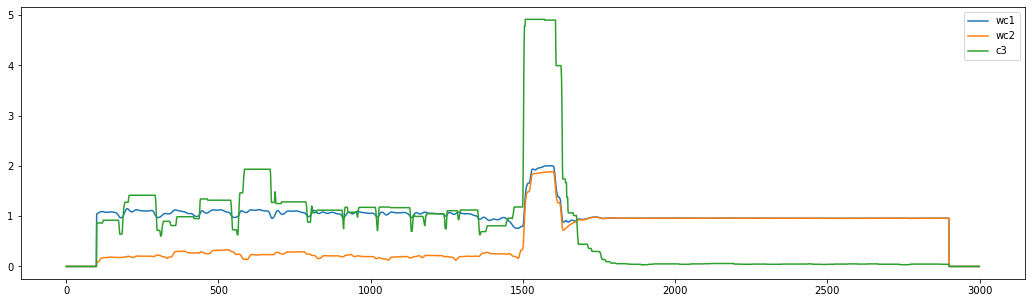

In [70]:
plt.plot(df['wc1'], label='wc1')
plt.plot(df['wc2'], label='wc2')
plt.plot(df['c3'], label='c3')
plt.legend()
plt.show()

### C4 - Angle between z-axis and vertical

In the paper is defined as $C_4[k] = atan2(\sqrt{(ã_x[k])^2 + (ã_z[k])^2}, -ã_y[k])$

Even if the window notation ã is used, there are no aggregators of the values inside ã.

The closest thing to the definition we can do is just compute the angle of the last sample of each window. 

In [71]:
Nv = 100 # 500ms window

def c4(df):
    df['c4'] = 0
    k = Nv

    w = window(df, k, Nv)
    while k < len(df)-Nv:
        latest_sample = np.array(w.iloc[-1, :3])
        angle = np.arctan2(np.sqrt(latest_sample[0]**2 + latest_sample[2]**2), -latest_sample[1])

        df.iloc[k, df.columns.get_loc("c4")] = angle
        k += 1
        w = window(df, k, Nv)
        
c4(df)

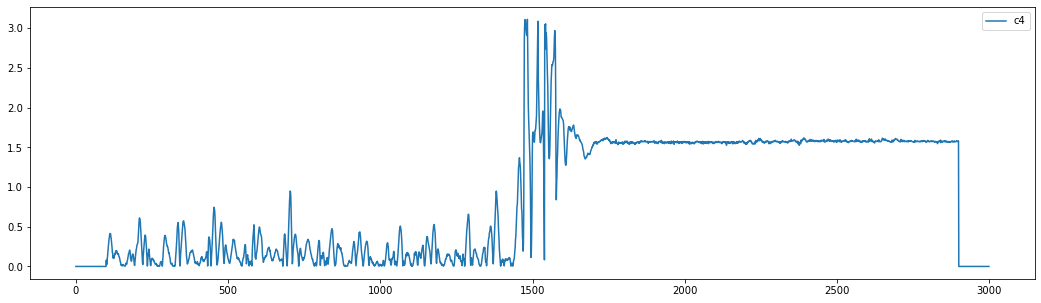

In [72]:
plt.plot(df['c4'], label='c4')
plt.legend()
plt.show()

### C5 - Orientation of person's trunk

In the paper is defined $C_5 = \sigma( atan(\frac{RMS(ã_x[k], ã_z[k])}{ã_y[k]}) )$

**I don't compute more features because I am just guessing what they meant in the papers**

Probably it would be a good idea to normalize all this features.

## How do you filter data?

The filter used in the paper is a **4th order IIR Butterworth low-pass filter with cut-off frequency of 5 Hz**

In [73]:
from scipy.signal import butter, filtfilt

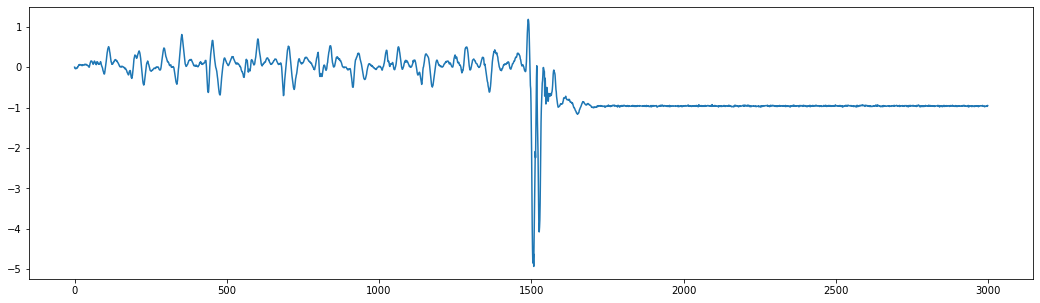

In [74]:
plt.plot(df.iloc[:,0])

plt.show()

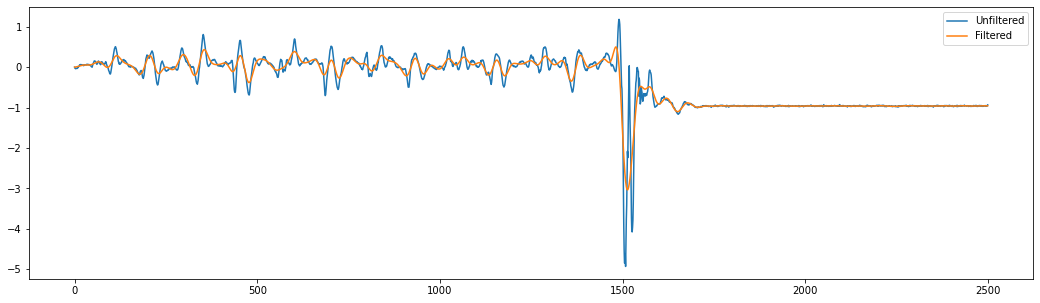

In [75]:
def filter_column(col):
    order = 4
    cutoff = 5
    fs = 200
    nyq = 0.5 * fs

    normal_cutoff = cutoff / nyq

    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, col)

filtered = filter_column(df.iloc[:,0])

plt.plot(df.iloc[:2500, 0], label='Unfiltered')
plt.plot(filtered[:2500], label='Filtered')
plt.legend()
plt.show()

In [76]:
df['f0'] = filter_column(df.iloc[:,0])
df['f1'] = filter_column(df.iloc[:,1])
df['f2'] = filter_column(df.iloc[:,2])

In [77]:
df

,0,1,2,c1,wc1,c2,wc2,c3,c4,f0,f1,f2
0,0.000000,-0.773438,-0.003021,0.773443,0.0,0.003021,0.0,0.0,0.0,-0.000102,-0.774630,-0.003026
1,-0.027344,-0.792969,-0.003098,0.793446,0.0,0.027519,0.0,0.0,0.0,0.001584,-0.793973,-0.003101
2,-0.031250,-0.824219,-0.003220,0.824817,0.0,0.031415,0.0,0.0,0.0,0.003316,-0.813197,-0.003177
3,-0.039062,-0.855469,-0.003342,0.856367,0.0,0.039205,0.0,0.0,0.0,0.005117,-0.832116,-0.003250
4,-0.027344,-0.882812,-0.003448,0.883243,0.0,0.027560,0.0,0.0,0.0,0.007006,-0.850546,-0.003322
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.964844,0.003906,0.000015,0.964852,0.0,0.964844,0.0,0.0,0.0,-0.957426,0.007024,0.000027
2996,-0.957031,-0.007812,-0.000031,0.957063,0.0,0.957031,0.0,0.0,0.0,-0.957111,0.007432,0.000029
2997,-0.957031,0.007812,0.000031,0.957063,0.0,0.957031,0.0,0.0,0.0,-0.956802,0.007804,0.000030
2998,-0.968750,0.007812,0.000031,0.968782,0.0,0.968750,0.0,0.0,0.0,-0.956508,0.008136,0.000032


## Labeling the data

Before trying any model training we need to label all the windows in the dataframe.
We will label 0 the regular points and 1 the outliers. (aka the falls)

In order to detect correctly the falls, I will slice the fall experiments manually.

For a quick experiment I will try to train a model using only this dataframe.
In fact contains ADL, fall and post fall windows.

In [78]:
df

,0,1,2,c1,wc1,c2,wc2,c3,c4,f0,f1,f2
0,0.000000,-0.773438,-0.003021,0.773443,0.0,0.003021,0.0,0.0,0.0,-0.000102,-0.774630,-0.003026
1,-0.027344,-0.792969,-0.003098,0.793446,0.0,0.027519,0.0,0.0,0.0,0.001584,-0.793973,-0.003101
2,-0.031250,-0.824219,-0.003220,0.824817,0.0,0.031415,0.0,0.0,0.0,0.003316,-0.813197,-0.003177
3,-0.039062,-0.855469,-0.003342,0.856367,0.0,0.039205,0.0,0.0,0.0,0.005117,-0.832116,-0.003250
4,-0.027344,-0.882812,-0.003448,0.883243,0.0,0.027560,0.0,0.0,0.0,0.007006,-0.850546,-0.003322
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.964844,0.003906,0.000015,0.964852,0.0,0.964844,0.0,0.0,0.0,-0.957426,0.007024,0.000027
2996,-0.957031,-0.007812,-0.000031,0.957063,0.0,0.957031,0.0,0.0,0.0,-0.957111,0.007432,0.000029
2997,-0.957031,0.007812,0.000031,0.957063,0.0,0.957031,0.0,0.0,0.0,-0.956802,0.007804,0.000030
2998,-0.968750,0.007812,0.000031,0.968782,0.0,0.968750,0.0,0.0,0.0,-0.956508,0.008136,0.000032


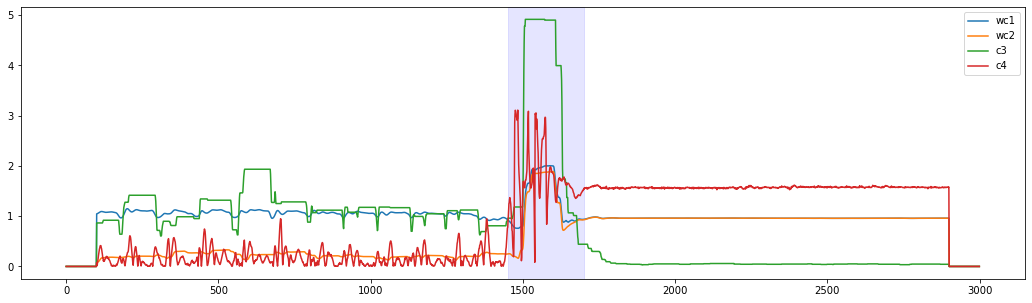

In [79]:
plt.axvspan(1450, 1700, color='blue', alpha=0.1)

plt.plot(df['wc1'], label='wc1')
plt.plot(df['wc2'], label='wc2')
plt.plot(df['c3'], label='c3')
plt.plot(df['c4'], label='c4')

plt.legend()
plt.show()

The slice above seems representative of the fall. So all the windows in it will be marked with a 1.

In [80]:
df['label'] = 0

df.iloc[1450:1700, df.columns.get_loc("label")] = 1

In [81]:
df[1400:1500]

,0,1,2,c1,wc1,c2,wc2,c3,c4,f0,f1,f2,label
1400,-0.074219,-0.972656,-0.003799,0.975491,0.937449,0.074316,0.255560,0.809234,0.076257,0.049916,-0.765614,-0.002991,0
1401,-0.050781,-0.949219,-0.003708,0.950583,0.939700,0.050916,0.255552,0.809234,0.053589,0.035434,-0.779970,-0.003047,0
1402,-0.085938,-0.917969,-0.003586,0.921990,0.941469,0.086012,0.255686,0.809234,0.093426,0.022851,-0.794020,-0.003102,0
1403,-0.050781,-0.867188,-0.003387,0.868680,0.942519,0.050894,0.255734,0.809234,0.058621,0.012240,-0.807847,-0.003156,0
1404,-0.042969,-0.812500,-0.003174,0.813642,0.942810,0.043086,0.255711,0.809234,0.052979,0.003616,-0.821562,-0.003209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.121094,-1.062500,-0.004150,1.069386,0.792709,0.121165,0.322896,1.183126,0.113547,-0.739294,-0.135213,-0.000528,1
1496,-0.214844,-1.191406,-0.004654,1.210631,0.796628,0.214894,0.323609,1.183126,0.178451,-0.920907,-0.120155,-0.000469,1
1497,-0.453125,-1.050781,-0.004105,1.144325,0.799130,0.453144,0.326737,1.183126,0.407148,-1.107643,-0.098507,-0.000385,1
1498,-0.535156,-0.601562,-0.002350,0.805155,0.797290,0.535161,0.331039,1.183126,0.727050,-1.297077,-0.070428,-0.000275,1


In [82]:
columns_index = [df.columns.get_loc(name) for name in ['wc1', 'wc2', 'c3', 'c4','label']]

dataset = df.iloc[:, columns_index]

In [83]:
dataset

,wc1,wc2,c3,c4,label
0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...
2995,0.0,0.0,0.0,0.0,0
2996,0.0,0.0,0.0,0.0,0
2997,0.0,0.0,0.0,0.0,0
2998,0.0,0.0,0.0,0.0,0


## Quick model

In [84]:
from sklearn.model_selection import train_test_split

X=dataset[['wc1', 'wc2', 'c3', 'c4']]  # Features
y=dataset['label']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

In [85]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [86]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print(f"Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(f"Precision:", metrics.precision_score(y_test, y_pred))
print(f"Recall:", metrics.recall_score(y_test, y_pred))
print(f"F1:", metrics.f1_score(y_test, y_pred))

metrics.confusion_matrix(y_test, y_pred)

Accuracy: 0.9988888888888889
Precision: 1.0
Recall: 0.9866666666666667
F1: 0.9932885906040269


array([[825,   0],
       [  1,  74]])

In [87]:
# Lets dump the model so we can load another dataset and see if it performs
from joblib import dump, load
dump(clf, 'treef04.joblib') 

['treef04.joblib']

## Quick model but cross-validated 10-fold

In [88]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier

X=np.array(dataset[['wc1', 'wc2', 'c3', 'c4']])  # Features
y=np.array(dataset['label'])  # Labels

clf=RandomForestClassifier(n_estimators=100)

cv=KFold(n_splits=10, shuffle=True, random_state=42)
    
cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1'])

{'fit_time': array([0.26034594, 0.34326005, 0.2449789 , 0.35473204, 0.23953819,
        0.34847593, 0.25356913, 0.24847078, 0.42812419, 0.42521501]),
 'score_time': array([0.01288509, 0.01603007, 0.01346087, 0.02613974, 0.01400876,
        0.01316404, 0.01311803, 0.01258612, 0.05284691, 0.01633787]),
 'test_accuracy': array([1.        , 1.        , 0.99666667, 1.        , 1.        ,
        0.99666667, 1.        , 1.        , 1.        , 0.99666667]),
 'test_precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.96666667, 1.        , 1.        , 1.        , 1.        ]),
 'test_recall': array([1.        , 1.        , 0.96153846, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.97142857]),
 'test_f1': array([1.        , 1.        , 0.98039216, 1.        , 1.        ,
        0.98305085, 1.        , 1.        , 1.        , 0.98550725])}